'''
원본데이터 - 로그데이터

원본데이터  - 유저 특성 데이터 - 클러스터링 이후에 결과 집단의 특성을 토대로 비즈니스 전략 수립 가능


            - 비즈니스 전략 데이터


1. 유저 분석을 위한 유저 기준으로 정리된 데이터 - 클러스터링
=> 유저특성지표

row의 단위 : 유저 1명
col의 단위 : 해당 유저에 대한 통계량

EDA해서 나온 요소들을 통합하기

	1) R, F, M
                - 가중치
                   R - 총금액을 고려해서 얼마 이상은 (기간 * 0.8)
                   F - 총금액을 고려해서 얼마 이상은 (기간 * 1.2)
	2) 구매횟수대비 쿠폰사용율
  	3) 평균구매주기


2. 마케팅, 비즈니스 전략을 위한 데이터
=> 경향성 지표


	1) ROAS 지표 = 광고비 대비 매출액(수익)
	   단위기간 중 총 광고비용이 높은 특정 기간
      	   특정 기간 중에 거래량이 많은 집단 특정
	   전략 : 1)결과값을 보고 저희 주관이 들어간 요소

	2) 오프라인 비용으로부터 초래되는 비효율 줄이기
                주장 : 오프라인 마케팅이 효과가 미비하다
                         효과가 상대적으로 좋은 온라인이 오프라인에 맞춰서 조정되는 것이 비효율이다
	   
                오프라인비용 : 일주일단위로 조정 - 비탄력적 요소
                온라인비용 : 하루 단위로 조정 - 탄력적 요소

	    온라인, 오프라인 7일 이동평균 상관관계 = 0.74

	   총 마케팅비용과 총매출 간의 관계        = 0.14
                온라인비용이동평균과 총매출간의 관계 = 0.2









'''

'''
목표1. 클러스터링 해보기
그것을 위한 숙제
1. RFM 간소화하기(클러스터링과의 비교군) => 7개 그룹정도?
    5 * 5 * 2 =
    - 참고 및 평가요소(+ 실루엣 점수)
    1) 클러스터링을 통해 나온 그룹을 어떤 그룹으로 정의할지의 참고사항
    2) 우리만의 클러스터링이 가지고 있는 요소(ex. 우리가 한 클러스터링의 vip는 ㅇㅇㅇ가 RFM에 비해 높다, 대신 ㅇㅇㅇ는 관대하다)
    분류된 고객층 중에서 특정층을 공략하기 => 최종목표
2. Monetary별 가중치 해결하기
3. EDA를 통한 유저 특성 컬럼 추가하기


목표2. ROAS에 요소 추가
'''

In [1]:
import numpy as np
import pandas as pd

import datetime as dt
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import re

In [2]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
df1 = pd.read_csv('/content/Onlinesales_info.csv')
df2 = pd.read_csv('/content/Customer_info.csv')
df3 = pd.read_csv('/content/Discount_info.csv')
df4 = pd.read_csv('/content/Marketing_info.csv')
df5 = pd.read_csv('/content/Tax_info.csv')

In [4]:
df = pd.merge(df1, df2, how='left', on='고객ID')
df = pd.merge(df, df5, how='left', on='제품카테고리')

df['거래날짜'] = pd.to_datetime(df['거래날짜'])
df['월'] = df['거래날짜'].dt.month

In [5]:
def month_shift(x):
    dict = {1:'Jan',
            2:'Feb',
            3:'Mar',
            4:'Apr',
            5:'May',
            6:'Jun',
            7:'Jul',
            8:'Aug',
            9:'Sep',
            10:'Oct',
            11:'Nov',
            12:'Dec'}

    return dict[x]

In [6]:
df['월'] = df['월'].apply(month_shift)

In [7]:
df = pd.merge(df, df3, how='left', on=['월', '제품카테고리'])

In [8]:
df4['날짜'] = pd.to_datetime(df4['날짜'])
df = pd.merge(df, df4, how='left', left_on='거래날짜', right_on='날짜')

df = df.drop('날짜', axis=1)

In [9]:
df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,0.10,Jan,OFF10,10.0,4500,2424.5
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,0.18,Jan,SALE10,10.0,4500,2424.5
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5


In [10]:
df.to_csv('merge.csv')

In [11]:
df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,0.10,Jan,OFF10,10.0,4500,2424.5
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,0.18,Jan,SALE10,10.0,4500,2424.5
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5


In [12]:
user_region = pd.DataFrame(df.groupby('고객ID')['고객지역'].apply(lambda x: x.value_counts().idxmax()))
user_region

,고객지역
고객ID,
USER_0000,New York
USER_0001,New York
USER_0002,California
USER_0003,California
USER_0004,Chicago
...,...
USER_1463,California
USER_1464,New York
USER_1465,Chicago


In [13]:
mode_category = pd.DataFrame(df.groupby('고객ID')['제품카테고리'].apply(lambda x: x.value_counts().idxmax()))
mode_category

,제품카테고리
고객ID,
USER_0000,Apparel
USER_0001,Nest-USA
USER_0002,Office
USER_0003,Apparel
USER_0004,Apparel
...,...
USER_1463,Apparel
USER_1464,Apparel
USER_1465,Apparel


In [14]:
df['쿠폰코드'] = df['쿠폰코드'].fillna(np.nan)
df['할인율'] = df['할인율'].fillna(0)

In [15]:
def true_discount(x):
    if x == 'Used':
        return 1
    else:
        return 0

In [16]:
df['true_discount'] = df['쿠폰상태'].apply(true_discount)
df['true_discount']

0        1
1        1
2        1
3        0
4        1
        ..
52919    0
52920    1
52921    1
52922    0
52923    0
Name: true_discount, Length: 52924, dtype: int64

In [17]:
df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용,true_discount
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,0.10,Jan,OFF10,10.0,4500,2424.5,1
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,0.18,Jan,SALE10,10.0,4500,2424.5,0
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5,1


In [18]:
df['총금액'] = (df['평균금액'] * (1 + df['GST']) * ((100 - (df['true_discount'] * df['할인율'])) / 100) * df['수량']) + df['배송료']

In [19]:
df['배송료'].describe()

count    52924.000000
mean        10.517630
std         19.475613
min          0.000000
25%          6.000000
50%          6.000000
75%          6.500000
max        521.360000
Name: 배송료, dtype: float64

In [20]:
df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용,true_discount,총금액
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1,158.6729
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1,158.6729
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,0.10,Jan,OFF10,10.0,4500,2424.5,1,8.5295
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,0.18,Jan,SALE10,10.0,4500,2424.5,0,109.9270
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5,1,24.0230


In [77]:
# 한 달 평균 사용금액 컬럼
# 가입기간에 따라 총금액이 달라질 수 있기 때문에 가입기간을 총금액으로 나누어 한 달에 얼마를 썼는지 알 수 있음 -> 어떤 유저가 돈을 꾸준히 써주는지 알 수 있음
df['한달평균사용금액'] = df['총금액'] / df['가입기간']

In [76]:
# 마지막 거래부터 며칠이 지났는지
df['거래날짜'] = pd.to_datetime(df['거래날짜'])

last_transaction_dates = df.groupby('고객ID')['거래날짜'].max()
last_transaction_dates

고객ID
USER_0000   2019-09-15
USER_0001   2019-11-02
USER_0002   2019-10-19
USER_0003   2019-12-14
USER_0004   2019-09-15
               ...    
USER_1463   2019-04-05
USER_1464   2019-10-05
USER_1465   2019-06-20
USER_1466   2019-10-23
USER_1467   2019-10-10
Name: 거래날짜, Length: 1468, dtype: datetime64[ns]

In [78]:
pd.set_option('display.max_columns', None)
df.head(20)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용,true_discount,총금액,총마케팅비용,ma_total_marketing,한달평균사용금액,마지막거래일로부터경과일수
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1,158.67290,6924.5,6924.5,13.222742,-1953
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1,158.67290,6924.5,6924.5,13.222742,-1953
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,0.10,Jan,OFF10,10.0,4500,2424.5,1,8.52950,6924.5,6924.5,0.710792,-1953
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,0.18,Jan,SALE10,10.0,4500,2424.5,0,109.92700,6924.5,6924.5,9.160583,-1953
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5,1,24.02300,6924.5,6924.5,2.001917,-1953
5,USER_1358,Transaction_0003,2019-01-01,Product_0854,Bags,15,5.15,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5,1,88.53950,6924.5,6924.5,7.378292,-1953
6,USER_1358,Transaction_0003,2019-01-01,Product_0880,Drinkware,15,3.08,6.5,Not Used,남,Chicago,12,0.18,Jan,EXTRA10,10.0,4500,2424.5,0,61.01600,6924.5,6924.5,5.084667,-1953
7,USER_1358,Transaction_0003,2019-01-01,Product_0885,Drinkware,15,10.31,6.5,Clicked,남,Chicago,12,0.18,Jan,EXTRA10,10.0,4500,2424.5,0,188.98700,6924.5,6924.5,15.748917,-1953
8,USER_1358,Transaction_0003,2019-01-01,Product_0898,Drinkware,5,9.27,6.5,Used,남,Chicago,12,0.18,Jan,EXTRA10,10.0,4500,2424.5,1,55.72370,6924.5,6924.5,4.643642,-1953
9,USER_0190,Transaction_0003,2019-01-01,Product_0914,Office,52,0.98,6.5,Used,남,California,43,0.10,Jan,OFF10,10.0,4500,2424.5,1,56.95040,6924.5,6924.5,1.324428,-1627


In [21]:
today_date = dt.datetime(2019,12,31)
rfm = pd.DataFrame(df.groupby('고객ID').agg({'거래ID':'nunique',
                          '총금액':'sum',
                          '거래날짜': lambda x: (today_date - x.max()).days}))

rfm = rfm.rename(columns={'거래ID':'Frequency',
                          '총금액':'Monetary',
                          '거래날짜':'Recency'})
rfm = rfm[['Recency', 'Frequency', 'Monetary']]

In [22]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1468 entries, USER_0000 to USER_1467
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    1468 non-null   int64  
 1   Frequency  1468 non-null   int64  
 2   Monetary   1468 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 45.9+ KB


In [23]:
coupon = pd.DataFrame(df.groupby('고객ID')['쿠폰상태'].value_counts() / df.groupby('고객ID')['쿠폰상태'].count())

coupon_core = pd.DataFrame(coupon.loc[([i if i != 0 else 0 for i in df['고객ID'].unique()], 'Used'), :].sort_index())

rfm = pd.merge(rfm, coupon_core, how='left', on='고객ID').fillna(0)
rfm.rename(columns={0: '쿠폰사용률'}, inplace=True)

In [24]:
rfm['ratio'] = rfm['쿠폰사용률'] / rfm['Frequency']
rfm = rfm.drop('쿠폰사용률', axis=1)

In [25]:
last_date = dt.datetime(2019, 12, 31)

date = df.sort_values(['고객ID', '거래날짜'])[['고객ID', '거래날짜']].drop_duplicates()
date['구매주기'] = date.groupby('고객ID')['거래날짜'].diff().fillna(last_date-date['거래날짜'])

avg_buying = pd.DataFrame(date.groupby('고객ID')['구매주기'].mean()).reset_index()


rfm = pd.merge(rfm, avg_buying, how='left', on='고객ID').rename(columns={'구매주기':'평균구매주기'})

rfm['평균구매주기'] = rfm['평균구매주기'].dt.days

In [26]:
# 클러스터링에 사용할 유저 특성 테이블
rfm = pd.merge(rfm, mode_category, how='left', on='고객ID')

In [27]:
rfm = rfm.rename(columns={'제품카테고리':'최다구매카테고리'})
rfm

,고객ID,Recency,Frequency,Monetary,ratio,평균구매주기,최다구매카테고리
0,USER_0000,107,1,174.98174,1.000000,107,Apparel
1,USER_0001,59,31,15686.84396,0.010753,168,Nest-USA
2,USER_0002,73,8,1689.55594,0.059783,155,Office
3,USER_0003,17,11,1467.43528,0.032086,17,Apparel
4,USER_0004,107,13,2007.42900,0.023504,107,Apparel
...,...,...,...,...,...,...,...
1463,USER_1463,270,3,860.68600,0.142857,270,Apparel
1464,USER_1464,87,19,3016.54372,0.021053,99,Apparel
1465,USER_1465,194,2,166.90750,0.187500,173,Apparel
1466,USER_1466,69,1,333.80000,0.000000,69,Nest-USA


In [28]:
rfm = pd.merge(rfm, user_region, how='left', on='고객ID')
rfm

,고객ID,Recency,Frequency,Monetary,ratio,평균구매주기,최다구매카테고리,고객지역
0,USER_0000,107,1,174.98174,1.000000,107,Apparel,New York
1,USER_0001,59,31,15686.84396,0.010753,168,Nest-USA,New York
2,USER_0002,73,8,1689.55594,0.059783,155,Office,California
3,USER_0003,17,11,1467.43528,0.032086,17,Apparel,California
4,USER_0004,107,13,2007.42900,0.023504,107,Apparel,Chicago
...,...,...,...,...,...,...,...,...
1463,USER_1463,270,3,860.68600,0.142857,270,Apparel,California
1464,USER_1464,87,19,3016.54372,0.021053,99,Apparel,New York
1465,USER_1465,194,2,166.90750,0.187500,173,Apparel,Chicago
1466,USER_1466,69,1,333.80000,0.000000,69,Nest-USA,Chicago


(array([358., 251., 180., 132., 101.,  81.,  63.,  42.,  40.,  38.]),
 array([6.99000000e+00, 7.60543706e+02, 1.51409741e+03, 2.26765112e+03,
        3.02120482e+03, 3.77475853e+03, 4.52831224e+03, 5.28186594e+03,
        6.03541965e+03, 6.78897335e+03, 7.54252706e+03]),
 <BarContainer object of 10 artists>)

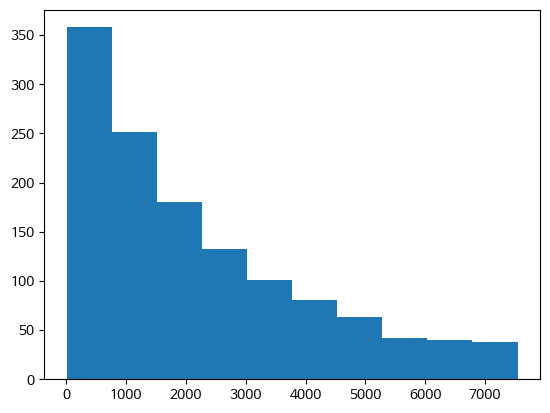

In [29]:
plt.hist(rfm[rfm['Monetary'] <= 7600]['Monetary'])

In [30]:
label_r = [4, 3, 2, 1]
label_f = [1, 2, 3, 4]
label_m = [1, 2, 3, 4]

## EDA
## bins를 만들 때
## 각 컬럼의 히스토그램과 boxplot 등을 봤을 때
## 특정 구간에 밀도가 너무 높아서
## 그 구간을 다시 분할하여 bins 를 생성

rfm["recency_score"] = pd.cut(rfm["Recency"], bins=[0, 30, 90, 180, 364], labels=label_r, include_lowest=True)
rfm["frequency_score"] = pd.cut(rfm["Frequency"], bins=[0, 12, 25, 53, 329], labels=label_f, include_lowest=True)
rfm["monetary_score"] = pd.cut(rfm["Monetary"], bins=[0, 760, 1750, 7594, 90000], labels=label_m, include_lowest=True)
rfm["RFM_SCORE"] = rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str) + rfm["monetary_score"].astype(str)

In [31]:
seg_map = {
    r'[1-2]1[1-4]': 'Hibernating',          # 1
    r'[1-2]2[1-4]': 'About to Sleep',       # 2
    r'[1-2][3-4][1-4]': 'At Risk',          # 3
    r'3[1-2][1-4]': 'Can\'t Lose',          # 4
    r'3[3-4][1-4]': 'Typical',              # 5
    r'4[1-2][1-2]': 'New Customers',        # 6
    r'4[1-2][3-4]': 'Loyal Customers',      # 7
    r'4[3-4][1-3]': 'Loyal Customers',      # 7
    r'4[3-4][4]': 'VIP'                     # 8
}

rfm['Segmentation'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

In [32]:
indexing = ['VIP',
            'Loyal Customers',
            'Typical',
            'New Customers',
            'At Risk',
            'Can\'t Lose',
            'About to Sleep',
            'Hibernating'
            ]

In [33]:
seg_stats = pd.DataFrame((rfm['Segmentation'].value_counts()/ rfm['Segmentation'].count()).round(4)*100)

In [34]:
seg_stats.reindex(index=indexing)

,count
Segmentation,
VIP,3.27
Loyal Customers,7.29
Typical,7.56
New Customers,5.52
At Risk,10.22
Can't Lose,13.62
About to Sleep,12.87
Hibernating,39.65


In [35]:
rfm.to_csv('user_feature.csv')

In [36]:
rfm.head()

,고객ID,Recency,Frequency,Monetary,ratio,평균구매주기,최다구매카테고리,고객지역,recency_score,frequency_score,monetary_score,RFM_SCORE,Segmentation
0,USER_0000,107,1,174.98174,1.000000,107,Apparel,New York,2,1,1,211,Hibernating
1,USER_0001,59,31,15686.84396,0.010753,168,Nest-USA,New York,3,3,4,334,Typical
2,USER_0002,73,8,1689.55594,0.059783,155,Office,California,3,1,2,312,Can't Lose
3,USER_0003,17,11,1467.43528,0.032086,17,Apparel,California,4,1,2,412,New Customers
4,USER_0004,107,13,2007.42900,0.023504,107,Apparel,Chicago,2,2,3,223,About to Sleep


## 클러스터링

### 1. k-means, pca

In [37]:
rfm.groupby('Segmentation')[['고객ID', 'Recency','Frequency','Monetary', 'ratio', '평균구매주기']].agg({'고객ID':'count', 'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean', 'ratio':'mean', '평균구매주기':'mean'}).reindex(index=indexing)


,고객ID,Recency,Frequency,Monetary,ratio,평균구매주기
Segmentation,,,,,,
VIP,48,14.729167,82.916667,18779.236879,0.005619,97.520833
Loyal Customers,107,16.728972,19.448598,3885.857418,0.021205,85.130841
Typical,111,56.639640,45.027027,9338.793550,0.008785,100.972973
New Customers,81,17.901235,5.567901,840.164773,0.097819,46.148148
At Risk,150,192.826667,42.753333,8668.394573,0.009279,147.426667
Can't Lose,200,60.830000,11.195000,2334.280137,0.059094,92.315000
About to Sleep,189,197.259259,17.931217,3423.765725,0.019522,174.317460
Hibernating,582,211.709622,5.292096,964.436884,0.123962,202.960481


In [38]:
rfm_cluster = rfm[['Recency', 'Frequency', 'Monetary', '평균구매주기', 'ratio']]

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_cluster_s = pd.DataFrame(data=scaler.fit_transform(rfm_cluster), columns=rfm_cluster.columns)

In [40]:
rfm_cluster_s

,Recency,Frequency,Monetary,평균구매주기,ratio
0,-0.365961,-0.686522,-0.599185,-0.475194,6.103502
1,-0.837001,0.515021,2.055096,0.196981,-0.378026
2,-0.699614,-0.406162,-0.340022,0.053730,-0.056783
3,-1.249160,-0.286007,-0.378030,-1.466928,-0.238254
4,-0.365961,-0.205905,-0.285630,-0.475194,-0.294478
...,...,...,...,...,...
1463,1.233611,-0.606419,-0.481852,1.320945,0.487519
1464,-0.562227,0.034404,-0.112957,-0.563348,-0.310541
1465,0.487799,-0.646470,-0.600567,0.252077,0.780018
1466,-0.738867,-0.686522,-0.572009,-0.893926,-0.448478


In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42, init='k-means++').fit(rfm_cluster_s.iloc[:, :5])
rfm_cluster_s['cluster_result'] = kmeans.labels_
rfm_cluster_s['RFM'] = rfm['Segmentation']


rfm['kmeans'] = rfm_cluster_s['cluster_result']
rfm.groupby('kmeans')[['고객ID', 'Recency','Frequency','Monetary']].agg({'고객ID':'count', 'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean'}).sort_values('Monetary', ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,고객ID,Recency,Frequency,Monetary
kmeans,,,,
2,5,29.200000,289.400000,70779.311820
6,29,62.517241,99.448276,22052.658105
0,209,87.803828,43.229665,9120.246718
4,429,53.086247,12.230769,2328.095305
1,251,301.490040,9.860558,2015.833812
3,492,167.512195,11.154472,2003.527520
5,53,200.886792,1.037736,138.506140


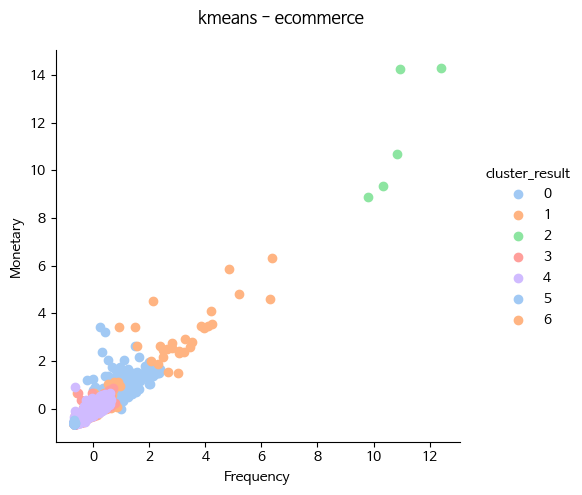

In [42]:
g = sns.FacetGrid(rfm_cluster_s, hue="cluster_result", height = 5, margin_titles = True,
                  palette = sns.color_palette("pastel", 5))
g.map_dataframe(plt.scatter, "Frequency", "Monetary")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("kmeans - ecommerce")
g.set_xlabels("Frequency")
g.set_ylabels("Monetary")

In [43]:
df_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=rfm_cluster_s.iloc[:, :5].columns)
df_centroids['size'] = rfm.groupby('kmeans')['고객ID'].count()

import plotly.graph_objects as go

def plot_radar_from_centroid(df_centroids):
  df_centroids = df_centroids.drop(['size'], axis = 1)
  fig = go.Figure()
  categories = df_centroids.columns
  for row in df_centroids.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[1].tolist(),
        theta=categories,
        fill='toself',
        name='cluster {}'.format(row[0])
    ))

  fig.update_layout(
      autosize=False,
      width=1000,
      height=800,
  )
  fig.show()

plot_radar_from_centroid(df_centroids)

In [44]:
from sklearn.metrics import silhouette_score, silhouette_samples

silhouette_avg = silhouette_score(rfm_cluster_s.iloc[:, :5], kmeans.labels_)
silhouette_avg

0.32828962205491274

In [45]:
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(rfm_cluster_s.iloc[:, :5])
    silhouette_avg = silhouette_score(rfm_cluster_s.iloc[:, :5], kmeans.labels_)
    print("k = {} -> silhouette index {}".format(k, silhouette_avg))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 3 -> silhouette index 0.3529815198260722


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 4 -> silhouette index 0.3732457524810157


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 5 -> silhouette index 0.3780058030896743


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 6 -> silhouette index 0.32608275787420254


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 7 -> silhouette index 0.32980367100195995


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 8 -> silhouette index 0.2819979096957311


In [46]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components = 2)
df_pca = pd.DataFrame(data=pca.fit_transform(rfm_cluster_s.iloc[:, :5]), columns=['pca1', 'pca2'])

kmeans_pca = KMeans(n_clusters=5, random_state=42, init='k-means++').fit(df_pca)

df_pca['cluster_pca_result'] = kmeans_pca.labels_
rfm['cluster_pca_result'] = kmeans_pca.labels_

rfm.groupby('cluster_pca_result')[['고객ID', 'Recency','Frequency','Monetary']].agg({'고객ID':'count', 'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean'}).sort_values('Monetary', ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,고객ID,Recency,Frequency,Monetary
cluster_pca_result,,,,
2,6,80.833333,270.666667,65739.449123
0,190,82.905263,54.310526,11655.267903
4,485,56.482474,13.507216,2587.410664
3,520,169.726923,11.334615,2049.280287
1,267,299.370787,8.400749,1752.439058


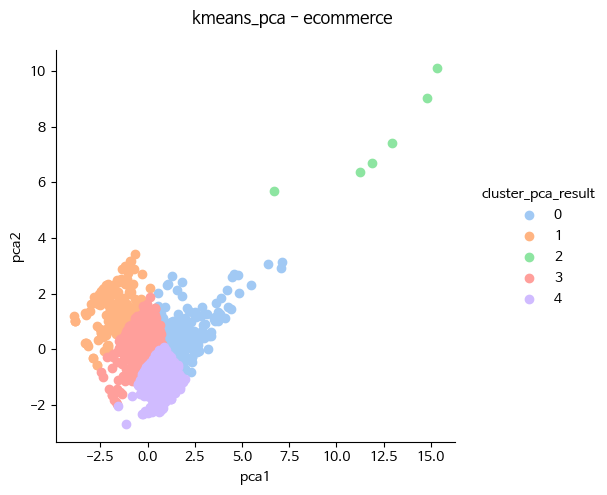

In [47]:
g = sns.FacetGrid(df_pca, hue="cluster_pca_result", height = 5, margin_titles = True,
                  palette = sns.color_palette("pastel", 5))
g.map_dataframe(plt.scatter, "pca1", "pca2")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("kmeans_pca - ecommerce")
g.set_xlabels("pca1")
g.set_ylabels("pca2")

### 2. t-SNE

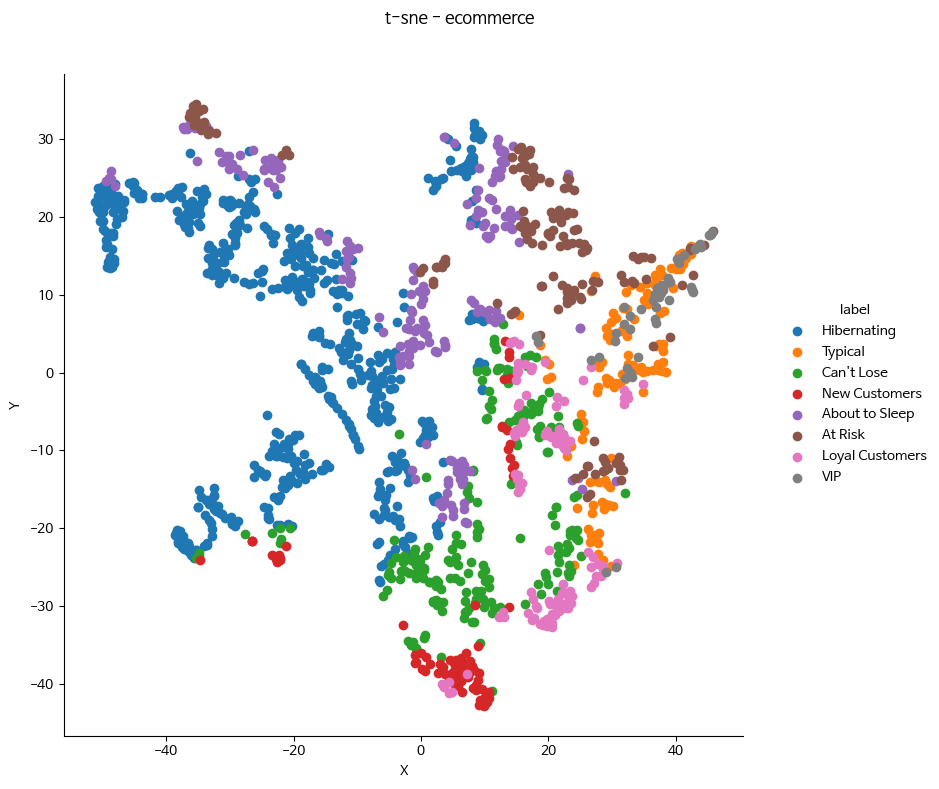

In [48]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

df_ecommerce_tsne = pd.DataFrame(data = tsne.fit_transform(rfm_cluster_s.iloc[:, :5]), columns = ['col1', 'col2'])
df_ecommerce_tsne['label'] = rfm_cluster_s['RFM']

h = sns.FacetGrid(df_ecommerce_tsne, hue="label", height = 8, margin_titles = True,
                  palette = sns.color_palette())
h.map_dataframe(plt.scatter, "col1", "col2")
h.add_legend()
h.fig.subplots_adjust(top=0.9)
h.fig.suptitle("t-sne - ecommerce")
h.set_xlabels("X")
h.set_ylabels("Y")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



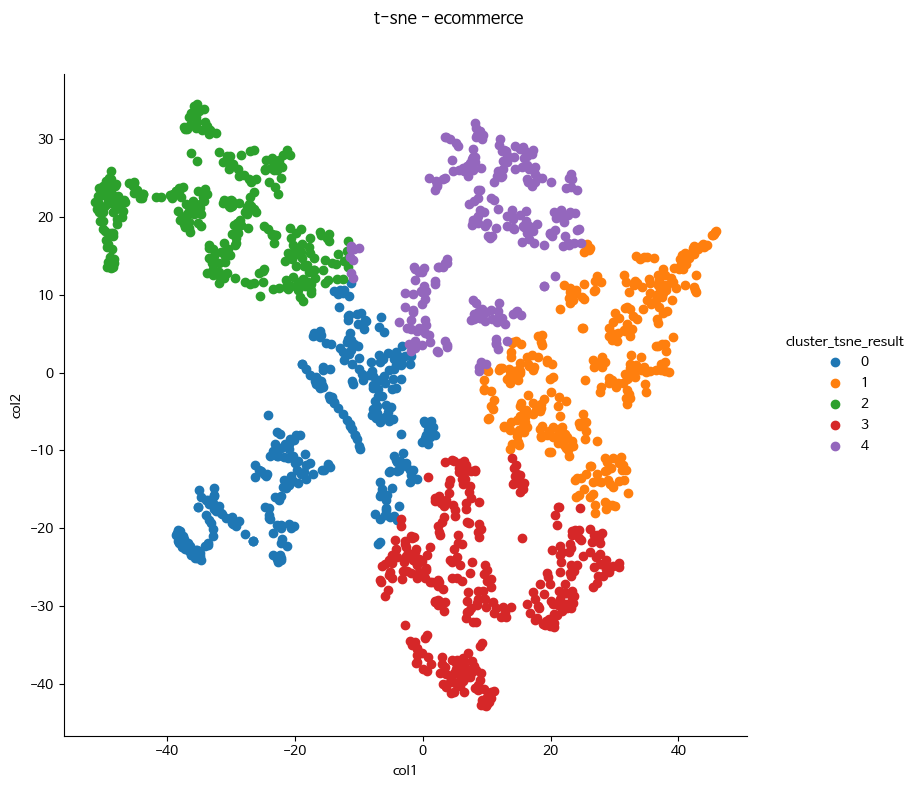

In [49]:


tsne_2 = TSNE(n_components=2)

df_ecommerce_tsne = pd.DataFrame(data = tsne.fit_transform(rfm_cluster_s.iloc[:, :5]), columns = ['col1', 'col2'])
df_ecommerce_tsne['label'] = rfm_cluster_s['RFM']


kmeans_tsne = KMeans(n_clusters=5, random_state=42, init='k-means++').fit(df_ecommerce_tsne[['col1', 'col2']])
df_ecommerce_tsne['cluster_tsne_result'] = kmeans_tsne.labels_



i = sns.FacetGrid(df_ecommerce_tsne, hue="cluster_tsne_result", height = 8, margin_titles = True,
                  palette = sns.color_palette())
i.map_dataframe(plt.scatter, "col1", "col2")
i.add_legend()
i.fig.subplots_adjust(top=0.9)
i.fig.suptitle("t-sne - ecommerce")
i.set_xlabels("col1")
i.set_ylabels("col2")

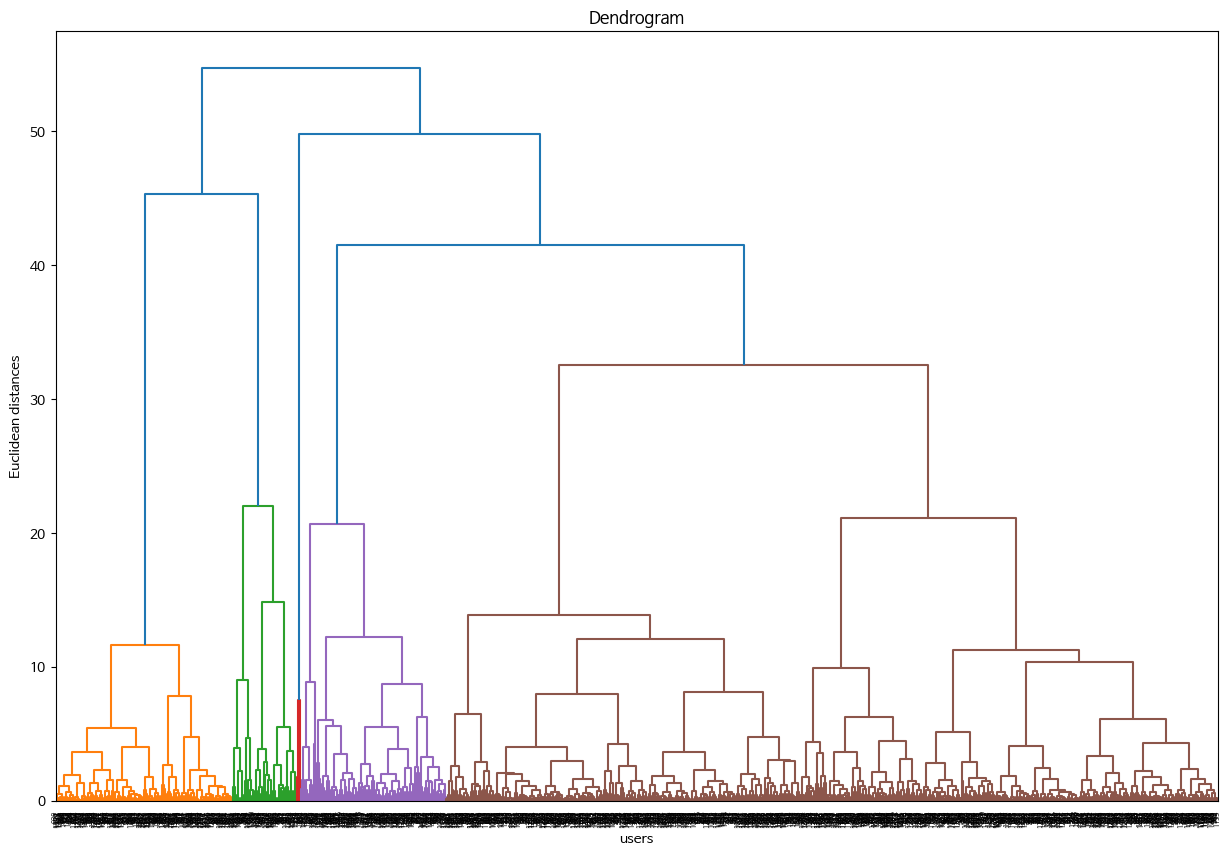

In [50]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

dend_ecommerce = rfm_cluster_s.iloc[:, :5]

plt.figure(figsize=(15,10))
plt.title('Dendrogram')
plt.xlabel('users')
plt.ylabel('Euclidean distances')
dgram = dendrogram(linkage(dend_ecommerce, method = 'ward'))
plt.show()


In [51]:
ecommerce_clustering = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
ecommerce_label = ecommerce_clustering.fit_predict(dend_ecommerce)
ecommerce_label

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



array([1, 4, 0, ..., 0, 0, 4])

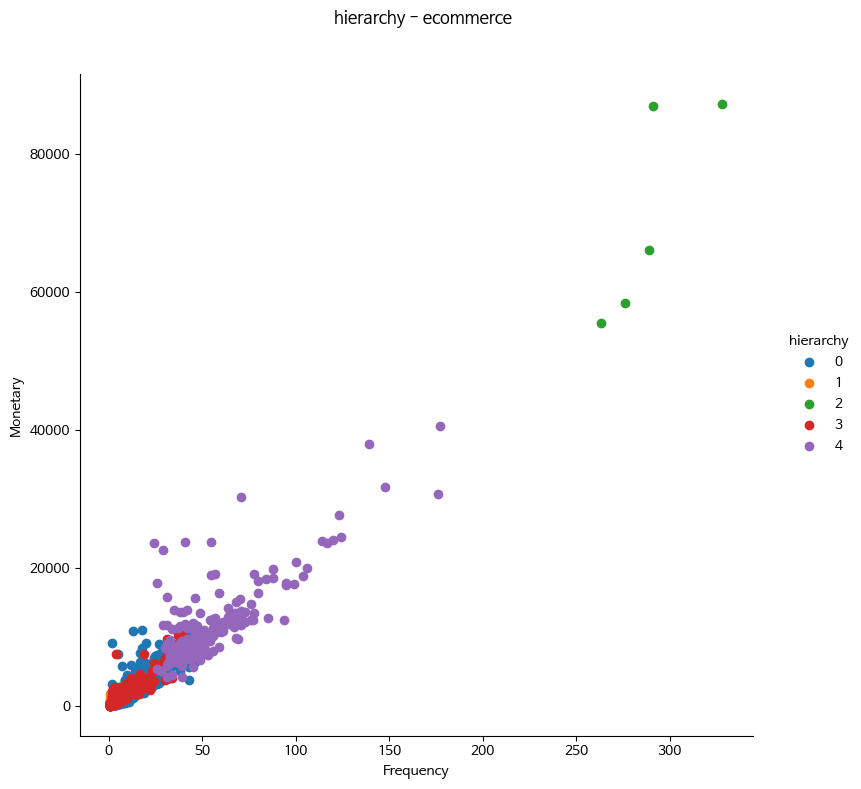

In [52]:
rfm['hierarchy'] = ecommerce_label

j = sns.FacetGrid(rfm, hue="hierarchy", height = 8, margin_titles = True,
                  palette = sns.color_palette())
j.map_dataframe(plt.scatter, "Frequency", "Monetary")
j.add_legend()
j.fig.subplots_adjust(top=0.9)
j.fig.suptitle("hierarchy - ecommerce")
j.set_xlabels("Frequency")
j.set_ylabels("Monetary")

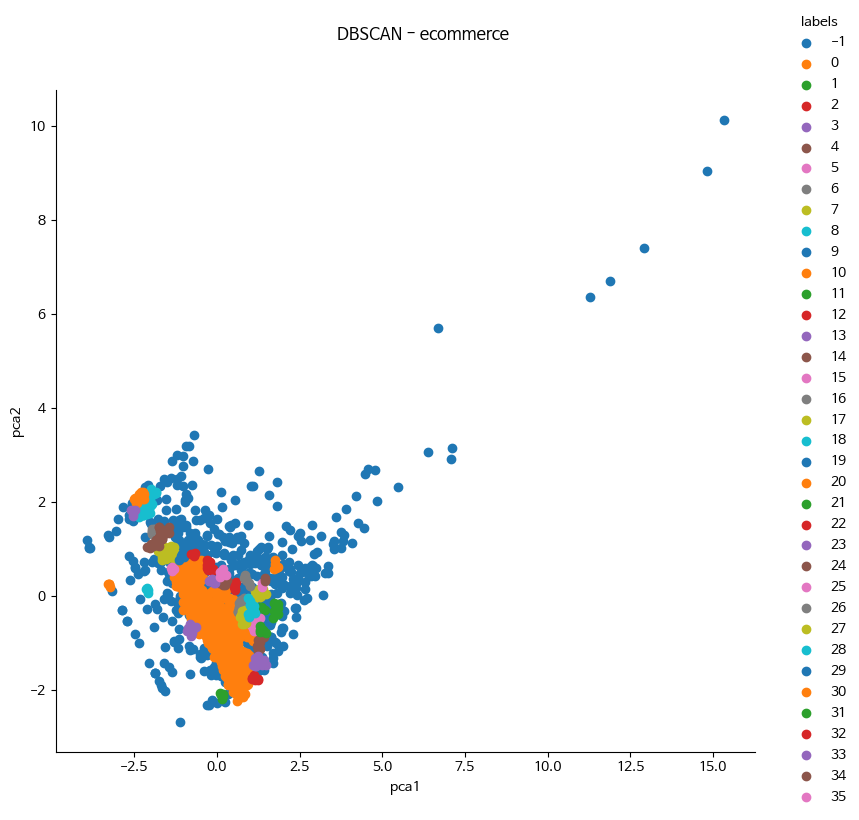

In [53]:
from sklearn.cluster import DBSCAN



dbscan = DBSCAN(eps=0.1, min_samples=4).fit(df_pca[['pca1', 'pca2']])
y_pred = dbscan.labels_

df_pca['labels'] = y_pred

j = sns.FacetGrid(df_pca, hue="labels", height = 8, margin_titles = True,
                  palette = sns.color_palette())
j.map_dataframe(plt.scatter, "pca1", "pca2")
j.add_legend()
j.fig.subplots_adjust(top=0.9)
j.fig.suptitle("DBSCAN - ecommerce")
j.set_xlabels("pca1")
j.set_ylabels("pca2")

### EDA

In [54]:
##### 비즈니스 인사이트 테이블

In [55]:
#### ROAS 지표

df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용,true_discount,총금액
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1,158.6729
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1,158.6729
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,0.10,Jan,OFF10,10.0,4500,2424.5,1,8.5295
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,0.18,Jan,SALE10,10.0,4500,2424.5,0,109.9270
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5,1,24.0230


In [56]:
df['총마케팅비용'] = df['오프라인비용'] + df['온라인비용']
df['ma_total_marketing'] = df['총마케팅비용'].rolling(7).mean().fillna(method='bfill')
df

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용,true_discount,총금액,총마케팅비용,ma_total_marketing
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,0.10,Jan,ELEC10,10.0,4500,2424.50,1,158.67290,6924.50,6924.50
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,0.10,Jan,ELEC10,10.0,4500,2424.50,1,158.67290,6924.50,6924.50
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,0.10,Jan,OFF10,10.0,4500,2424.50,1,8.52950,6924.50,6924.50
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.50,Not Used,남,...,0.18,Jan,SALE10,10.0,4500,2424.50,0,109.92700,6924.50,6924.50
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.50,Used,남,...,0.18,Jan,AIO10,10.0,4500,2424.50,1,24.02300,6924.50,6924.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0504,Transaction_25056,2019-12-31,Product_0976,Nest-USA,1,121.30,6.50,Clicked,여,...,0.10,Dec,ELEC30,30.0,4000,2058.75,0,139.93000,6058.75,6058.75
52920,USER_0504,Transaction_25057,2019-12-31,Product_0413,Apparel,1,48.92,6.50,Used,여,...,0.18,Dec,SALE30,30.0,4000,2058.75,1,46.90792,6058.75,6058.75
52921,USER_0504,Transaction_25058,2019-12-31,Product_0989,Nest-USA,1,151.88,6.50,Used,여,...,0.10,Dec,ELEC30,30.0,4000,2058.75,1,123.44760,6058.75,6058.75
52922,USER_0562,Transaction_25059,2019-12-31,Product_0985,Nest-USA,5,80.52,6.50,Clicked,여,...,0.10,Dec,ELEC30,30.0,4000,2058.75,0,449.36000,6058.75,6058.75


In [57]:
marketing = df[['거래날짜', '총마케팅비용']].drop_duplicates().reset_index(drop=True)

marketing2 = df[['거래날짜', '총마케팅비용']].drop_duplicates().reset_index(drop=True)
marketing2['ma_total_marketing'] = marketing2['총마케팅비용'].rolling(7).mean().fillna(method='bfill')
marketing2 = marketing2.rename(columns={'ma_total_marketing':'총마케팅비용(7일ma)'})
marketing2

,거래날짜,총마케팅비용,총마케팅비용(7일ma)
0,2019-01-01,6924.50,7477.351429
1,2019-01-02,7980.36,7477.351429
2,2019-01-03,6076.38,7477.351429
3,2019-01-04,7428.55,7477.351429
4,2019-01-05,8555.30,7477.351429
...,...,...,...
360,2019-12-27,7396.87,6754.795714
361,2019-12-28,7246.84,6702.525714
362,2019-12-29,6546.58,6664.971429
363,2019-12-30,4674.31,6375.631429


In [58]:
sales = df.groupby('거래날짜')['총금액'].sum().reset_index()
sales

,거래날짜,총금액
0,2019-01-01,9039.42048
1,2019-01-02,15269.39436
2,2019-01-03,29145.65155
3,2019-01-04,19500.23722
4,2019-01-05,21260.25480
...,...,...
360,2019-12-27,14371.81383
361,2019-12-28,11192.15088
362,2019-12-29,12299.47787
363,2019-12-30,8440.30569


In [59]:
roas1 = pd.merge(marketing, sales, how='left', on='거래날짜')
roas1['ratio'] = roas1['총금액'] / roas1['총마케팅비용']
roas1.sort_values('ratio', ascending=False).head(10)

,거래날짜,총마케팅비용,총금액,ratio
150,2019-05-31,1510.30,25596.54440,16.947987
29,2019-01-30,1681.86,22468.06098,13.359055
94,2019-04-05,4842.68,59951.48052,12.379815
151,2019-06-01,820.25,10140.35572,12.362518
31,2019-02-01,1392.67,17027.52846,12.226535
26,2019-01-27,1687.86,20095.25379,11.905759
23,2019-01-24,1560.02,17620.19628,11.294853
213,2019-08-02,3655.96,40533.19244,11.086881
149,2019-05-30,1762.38,18826.97940,10.682701
30,2019-01-31,2080.14,22123.26392,10.635469


In [60]:
roas2 = pd.merge(marketing2, sales, how='left', on='거래날짜')
roas2['ratio'] = roas2['총금액'] / roas2['총마케팅비용(7일ma)']
roas2.sort_values('ratio', ascending=False).head(10)


,거래날짜,총마케팅비용,총마케팅비용(7일ma),총금액,ratio
94,2019-04-05,4842.68,4289.407143,59951.48052,13.976636
29,2019-01-30,1681.86,1788.870000,22468.06098,12.559918
213,2019-08-02,3655.96,3241.630000,40533.19244,12.503954
30,2019-01-31,2080.14,1863.172857,22123.26392,11.873973
150,2019-05-31,1510.30,2243.272857,25596.54440,11.410357
330,2019-11-27,5819.58,5001.338571,56662.02888,11.329373
198,2019-07-18,4408.61,3999.448571,42947.02071,10.738236
107,2019-04-18,5476.58,5430.738571,54471.40715,10.030202
31,2019-02-01,1392.67,1758.561429,17027.52846,9.682646
26,2019-01-27,1687.86,2193.951429,20095.25379,9.159389


<Axes: xlabel='거래날짜', ylabel='ratio'>

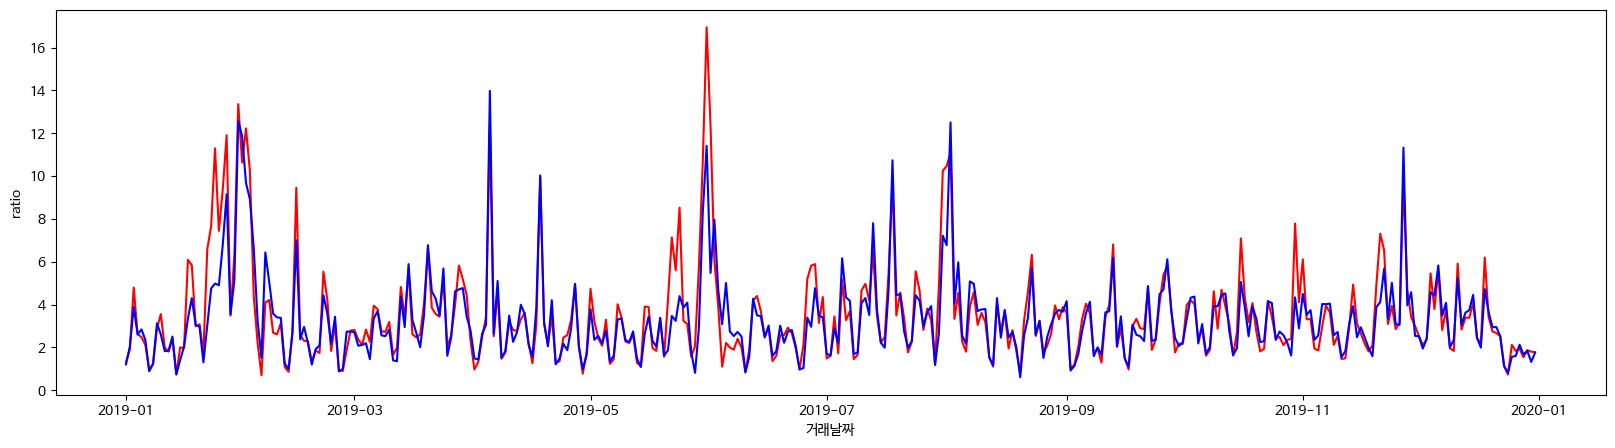

In [61]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=roas1, x='거래날짜', y='ratio', color='red')
sns.lineplot(data=roas2, x='거래날짜', y='ratio', color='blue')


# ratio(빨강) = 총비용 / 총마케팅비용
# ratio(파랑) = 총비용 / 총마케팅비용(이동평균)

# 총마케팅비용(이동평균) - 원본의 고점을 낮게 만드는 효과

# 마케팅의 특성상 직관적으로 볼때는 이동평균을 하는게 맞아보이는데


In [62]:
week = []
cut = 0


for i in range(1, 54):
    for j in range(7):
        week.append(i)
        if len(week) == len(roas1):
            break
    if len(week) == len(roas1):
        break

roas1['week'] = np.array(week).reshape(len(roas1), -1)
roas1

,거래날짜,총마케팅비용,총금액,ratio,week
0,2019-01-01,6924.50,9039.42048,1.305426,1
1,2019-01-02,7980.36,15269.39436,1.913372,1
2,2019-01-03,6076.38,29145.65155,4.796549,1
3,2019-01-04,7428.55,19500.23722,2.625040,1
4,2019-01-05,8555.30,21260.25480,2.485039,1
...,...,...,...,...,...
360,2019-12-27,7396.87,14371.81383,1.942959,52
361,2019-12-28,7246.84,11192.15088,1.544418,52
362,2019-12-29,6546.58,12299.47787,1.878764,52
363,2019-12-30,4674.31,8440.30569,1.805679,52


In [63]:
week_core = pd.DataFrame(roas1.groupby('week')[['총마케팅비용', '총금액']].sum()).reset_index()
week_core['ratio_week'] = week_core['총금액'] / week_core['총마케팅비용']
week_core.sort_values('ratio_week', ascending=False).head(10)

,week,총마케팅비용,총금액,ratio_week
21,22,10081.86,82926.69858,8.225337
3,4,13710.42,110229.52235,8.039836
4,5,13870.26,105175.22745,7.582787
30,31,21959.29,138445.68213,6.304652
28,29,28218.83,125851.33122,4.459835
20,21,18022.79,76393.20878,4.238700
46,47,33355.78,139378.94608,4.178555
47,48,37320.98,155668.44771,4.171071
11,12,26066.40,108427.85349,4.159679
13,14,31863.55,132045.72795,4.144100


<Axes: xlabel='week', ylabel='총마케팅비용'>

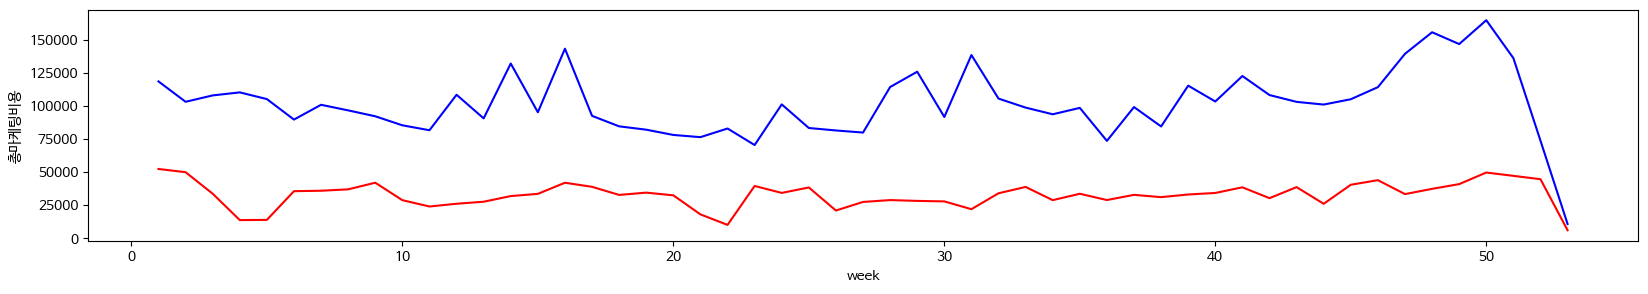

In [64]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=week_core, x='week', y='총마케팅비용', color='red')
sns.lineplot(data=week_core, x='week', y='총금액', color='blue')


<Axes: xlabel='week', ylabel='ratio_week'>

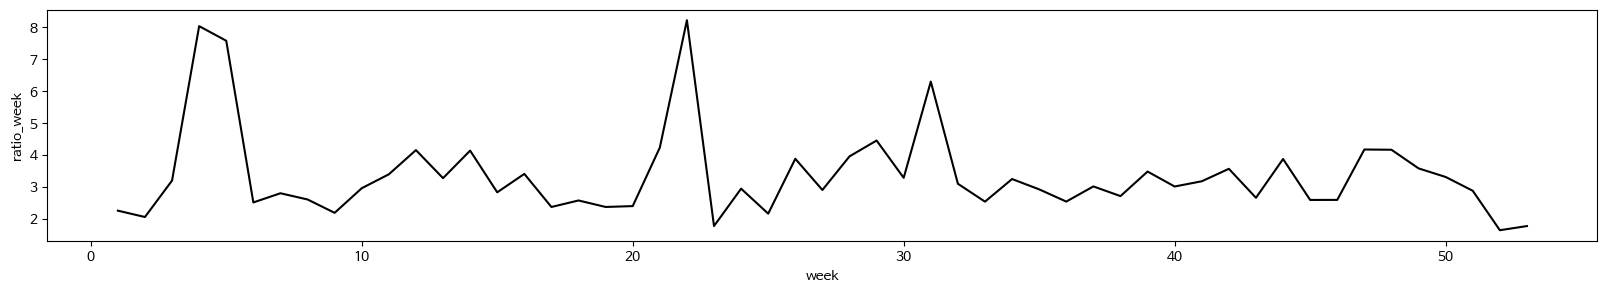

In [65]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=week_core, x='week', y='ratio_week', color='black')